In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lcdb
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

In [2]:
def evaluate_nonmonotonicity(interval, threshold):
    return threshold <= interval

In [3]:
@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UserWarning)
@ignore_warnings(category=RuntimeWarning)
def evaluate_learningcurve(learning_curve, limit):
    threshold = 0

    Y_distances = []
    min = np.min(learning_curve)
    max = np.max(learning_curve)
    learning_curve = np.array(learning_curve)

    for i in range(1, len(learning_curve)):
        Y_distances.append(learning_curve[i] - learning_curve[i-1])
        threshold += np.abs(learning_curve[i] - learning_curve[i-1])

    threshold = limit * threshold / len(learning_curve)
    increasing = True

    current_interval = 0
    occurances = 0
    significances = []

    if Y_distances[0] < 0:
        increasing = False
        current_interval += np.abs(Y_distances[0])

    non_monotone = False


    for i in range(1, len(Y_distances)):
        if increasing == (Y_distances[i] < 0):
            increasing = not increasing
            if evaluate_nonmonotonicity(current_interval, threshold) and increasing and Y_distances[i-1] < 0:
                occurances += 1
                significances.append(current_interval/(max - min))
                non_monotone = True
            current_interval = np.abs(Y_distances[i])
        elif i == len(Y_distances) - 1 and evaluate_nonmonotonicity(current_interval, threshold) and Y_distances[i] < 0:
            count_end = True
            occurances += 1
            significances.append(current_interval/(max - min))
            non_monotone = True
        else:
            current_interval += np.abs(Y_distances[i])

    significance = 0

    if len(significances) > 0:
        significance = np.max(significances)


    return non_monotone, occurances, significance

In [4]:
def plot_learningcurve(anchors, scores, starting_point, ending_point, flag):
    plt.figure(figsize=(10, 4))
    plt.plot(anchors, scores)
    if flag:
        plt.scatter(anchors[starting_point], scores[starting_point],  color="red")
        plt.scatter(anchors[ending_point], scores[ending_point],  color="green")
        plt.plot(anchors[starting_point:ending_point+1], scores[starting_point:ending_point+1])
    plt.title("Plot of learning curve")
    plt.xlabel("Number of training instances")
    plt.ylabel("Accuracy")
    plt.show()

In [5]:
def compute_data_occurences(occurances):
    occ1, occ2, occ3, occ4 = 0, 0, 0, 0

    for occurence in occurances:
        if occurence <= 2:
            occ1 += 1
        elif occurence <= 4:
            occ2 += 1
        elif occurence <= 6:
            occ3 += 1
        else:
            occ4 += 1

    return occ1, occ2, occ3, occ4

def compute_data_significances(significances):
    sign1, sign2, sign3, sign4 = 0, 0, 0, 0

    for significance in significances:
        if significance <= 0.25:
            sign1 += 1
        elif significance <= 0.5:
            sign2 += 1
        elif significance <= 0.75:
            sign3 += 1
        else:
            sign4 += 1

    return sign1, sign2, sign3, sign4



In [6]:
to_consider = ['sklearn.discriminant_analysis.LinearDiscriminantAnalysis', 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis', 'sklearn.linear_model.SGDClassifier']
exp_df = lcdb.get_all_curves('accuracy')
exp_df = exp_df.loc[exp_df.groupby(['openmlid', 'learner'])['size_train'].idxmax()]

lda = exp_df[exp_df['learner'] == to_consider[0]]


class_1 = 0  # monotonic
class_0 = 0  # non-monotonic
occurancesLDA = []
significancesLDA = []
occurancesQDA = []
significancesQDA = []
occurancesSGD = []
significancesSGD = []

rows = []


for el in to_consider:
    lda = exp_df[exp_df['learner'] == el]
    for idx, row in tqdm(lda.iterrows()):
        curve = lcdb.get_curve(row['openmlid'], row['learner'])
        anchors, scores_train, scores_valid, scores_test = curve
        actual_curve = [sub[1] for sub in scores_valid]
        flag, occurances, significance = evaluate_learningcurve(actual_curve, 0.8)
        rows.append([row['learner'], row['openmlid'], flag, occurances, significance])
        if flag:
            print(f"{row['learner']} on {row['openmlid']};non-monotonic: {flag}")
            class_1 += 1

            match row['learner']:
                case 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis':
                     occurancesLDA.append(occurances)
                     significancesLDA.append(significance)
                case 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis':
                     occurancesQDA.append(occurances)
                     significancesQDA.append(significance)
                case 'sklearn.linear_model.SGDClassifier':
                     occurancesSGD.append(occurances)
                     significancesSGD.append(significance)

        else:
            print(f"{row['learner']} on {row['openmlid']} is non-monotonic: {flag}, size: {len(anchors)}")
            class_0 += 1

print("Class 0: (Monotone)", class_0)
print("Class 1: (Non-Monotone)", class_1)
print("Occurances LDA:", occurancesLDA)
print("Significances LDA:", significancesLDA)
print("Occurances QDA:", occurancesQDA)
print("Significances QDA:", significancesQDA)
print("Occurances SGD:", occurancesSGD)
print("Significances SGD:", significancesSGD)

1it [00:03,  3.75s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 6 is non-monotonic: False, size: 20


2it [00:05,  2.80s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 11 is non-monotonic: False, size: 10


3it [00:07,  2.48s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 12;non-monotonic: True


4it [00:10,  2.32s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 14;non-monotonic: True


5it [00:12,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 16 is non-monotonic: False, size: 14


6it [00:14,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 18;non-monotonic: True


7it [00:16,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 21 is non-monotonic: False, size: 14


8it [00:18,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 22;non-monotonic: True


9it [00:20,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 23;non-monotonic: True


10it [00:22,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 26 is non-monotonic: False, size: 20


11it [00:24,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 28;non-monotonic: True


12it [00:26,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 30;non-monotonic: True


13it [00:28,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 32 is non-monotonic: False, size: 20


14it [00:30,  2.08s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 36 is non-monotonic: False, size: 14


15it [00:33,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 44;non-monotonic: True


16it [00:35,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 54;non-monotonic: True


17it [00:37,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 55;non-monotonic: True


18it [00:39,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 60;non-monotonic: True


19it [00:41,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 61 is non-monotonic: False, size: 6


20it [00:43,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 181;non-monotonic: True


21it [00:45,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 182;non-monotonic: True


22it [00:47,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 185;non-monotonic: True


23it [00:49,  2.09s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 201;non-monotonic: True


24it [00:52,  2.09s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 273;non-monotonic: True


25it [00:54,  2.08s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 293;non-monotonic: True


26it [00:56,  2.08s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 299;non-monotonic: True


27it [00:58,  2.07s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 300;non-monotonic: True


28it [01:00,  2.06s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 346;non-monotonic: True


29it [01:02,  2.06s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 351;non-monotonic: True


30it [01:04,  2.05s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 354;non-monotonic: True


31it [01:06,  2.06s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 357;non-monotonic: True


32it [01:08,  2.05s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 380 is non-monotonic: False, size: 4


33it [01:11,  2.26s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 389;non-monotonic: True


34it [01:14,  2.55s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 390;non-monotonic: True


35it [01:16,  2.49s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 391;non-monotonic: True


36it [01:19,  2.47s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 392 is non-monotonic: False, size: 12


37it [01:21,  2.37s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 393;non-monotonic: True


38it [01:23,  2.27s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 395;non-monotonic: True


39it [01:25,  2.25s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 396;non-monotonic: True


40it [01:27,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 398;non-monotonic: True


41it [01:29,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 399;non-monotonic: True


42it [01:31,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 401 is non-monotonic: False, size: 12


43it [01:33,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 446 is non-monotonic: False, size: 8


44it [01:36,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 554;non-monotonic: True


45it [01:38,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 679;non-monotonic: True


46it [01:40,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 715;non-monotonic: True


47it [01:42,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 718;non-monotonic: True


48it [01:44,  2.08s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 720;non-monotonic: True


49it [01:46,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 722 is non-monotonic: False, size: 20


50it [01:48,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 723;non-monotonic: True


51it [01:50,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 727;non-monotonic: True


52it [01:53,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 728;non-monotonic: True


53it [01:55,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 734;non-monotonic: True


54it [01:57,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 735;non-monotonic: True


55it [01:59,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 737;non-monotonic: True


56it [02:01,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 740;non-monotonic: True


57it [02:03,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 741;non-monotonic: True


58it [02:05,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 743;non-monotonic: True


59it [02:08,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 751;non-monotonic: True


60it [02:10,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 752;non-monotonic: True


61it [02:12,  2.31s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 761;non-monotonic: True


62it [02:15,  2.30s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 772;non-monotonic: True


63it [02:17,  2.25s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 797;non-monotonic: True


64it [02:19,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 799;non-monotonic: True


65it [02:21,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 803;non-monotonic: True


66it [02:24,  2.34s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 806;non-monotonic: True


67it [02:26,  2.27s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 807;non-monotonic: True


68it [02:28,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 813;non-monotonic: True


69it [02:30,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 816;non-monotonic: True


70it [02:33,  2.46s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 819 is non-monotonic: False, size: 18


71it [02:37,  2.96s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 821;non-monotonic: True


72it [02:40,  3.00s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 822;non-monotonic: True


73it [02:44,  3.04s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 823 is non-monotonic: False, size: 22


74it [02:48,  3.39s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 833;non-monotonic: True


75it [02:52,  3.53s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 837;non-monotonic: True


76it [02:55,  3.48s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 843;non-monotonic: True


77it [02:58,  3.40s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 845;non-monotonic: True


78it [03:01,  3.24s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 846;non-monotonic: True


79it [03:04,  3.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 847 is non-monotonic: False, size: 18


80it [03:08,  3.26s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 849;non-monotonic: True


81it [03:10,  3.05s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 866;non-monotonic: True


82it [03:13,  3.02s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 871;non-monotonic: True


83it [03:16,  2.90s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 881;non-monotonic: True


84it [03:18,  2.69s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 897;non-monotonic: True


85it [03:20,  2.52s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 901;non-monotonic: True


86it [03:22,  2.41s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 903;non-monotonic: True


87it [03:24,  2.34s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 904;non-monotonic: True


88it [03:27,  2.28s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 910;non-monotonic: True


89it [03:29,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 912;non-monotonic: True


90it [03:31,  2.27s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 913;non-monotonic: True


91it [03:33,  2.24s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 914;non-monotonic: True


92it [03:35,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 917;non-monotonic: True


93it [03:37,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 923;non-monotonic: True


94it [03:39,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 930;non-monotonic: True


95it [03:42,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 934;non-monotonic: True


96it [03:44,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 958 is non-monotonic: False, size: 14


97it [03:46,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 959;non-monotonic: True


98it [03:48,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 966;non-monotonic: True


99it [03:50,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 976 is non-monotonic: False, size: 18


100it [03:52,  2.16s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 979;non-monotonic: True


101it [03:55,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 980;non-monotonic: True


102it [03:57,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 991;non-monotonic: True


103it [03:59,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1041;non-monotonic: True


104it [04:01,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1042;non-monotonic: True


105it [04:03,  2.08s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1053;non-monotonic: True


106it [04:05,  2.08s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1067;non-monotonic: True


107it [04:07,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1083 is non-monotonic: False, size: 8


108it [04:09,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1084 is non-monotonic: False, size: 8


109it [04:12,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1085;non-monotonic: True


110it [04:14,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1086 is non-monotonic: False, size: 8


111it [04:16,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1087 is non-monotonic: False, size: 8


112it [04:18,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1088 is non-monotonic: False, size: 10


113it [04:20,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1120;non-monotonic: True


114it [04:22,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1128;non-monotonic: True


115it [04:24,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1130;non-monotonic: True


116it [04:26,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1134;non-monotonic: True


117it [04:29,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1161;non-monotonic: True


118it [04:31,  2.09s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1233;non-monotonic: True


119it [04:33,  2.09s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1235;non-monotonic: True


120it [04:35,  2.09s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1236 is non-monotonic: False, size: 32


121it [04:37,  2.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1448;non-monotonic: True


122it [04:39,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1450;non-monotonic: True


123it [04:41,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1457;non-monotonic: True


124it [04:43,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1465 is non-monotonic: False, size: 6


125it [04:46,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1468;non-monotonic: True


126it [04:48,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1475;non-monotonic: True


127it [04:50,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1477;non-monotonic: True


128it [04:52,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1479;non-monotonic: True


129it [04:54,  2.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1483;non-monotonic: True


130it [04:56,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1485;non-monotonic: True


131it [04:58,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1488;non-monotonic: True


132it [05:01,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1489;non-monotonic: True


133it [05:03,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1494;non-monotonic: True


134it [05:05,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1499 is non-monotonic: False, size: 8


135it [05:07,  2.23s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1503;non-monotonic: True


136it [05:09,  2.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1509;non-monotonic: True


137it [05:11,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1515 is non-monotonic: False, size: 10


138it [05:13,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1566;non-monotonic: True


139it [05:16,  2.10s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1567;non-monotonic: True


140it [05:18,  2.11s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 4134;non-monotonic: True


141it [05:20,  2.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 4538;non-monotonic: True


142it [05:22,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 23512;non-monotonic: True


143it [05:24,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 23517;non-monotonic: True


144it [05:26,  2.12s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40498;non-monotonic: True


145it [05:29,  2.21s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40685;non-monotonic: True


146it [05:31,  2.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40971;non-monotonic: True


147it [05:33,  2.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40975 is non-monotonic: False, size: 14


148it [05:35,  2.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40981 is non-monotonic: False, size: 12


149it [05:37,  2.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40982;non-monotonic: True


150it [05:40,  2.40s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40984;non-monotonic: True


151it [05:43,  2.36s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40996;non-monotonic: True


152it [05:47,  3.02s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41027;non-monotonic: True


153it [05:52,  3.56s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41142;non-monotonic: True


154it [05:57,  4.06s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41144;non-monotonic: True


155it [06:00,  3.68s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41145;non-monotonic: True


156it [06:02,  3.29s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41146;non-monotonic: True


157it [06:05,  2.98s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41150;non-monotonic: True


158it [06:07,  2.71s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41156;non-monotonic: True


159it [06:09,  2.65s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41157;non-monotonic: True


160it [06:12,  2.59s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41158;non-monotonic: True


161it [06:14,  2.50s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41159;non-monotonic: True


162it [06:17,  2.58s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41161;non-monotonic: True


163it [06:19,  2.58s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41163;non-monotonic: True


164it [06:23,  3.00s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41164;non-monotonic: True


165it [06:28,  3.53s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41165;non-monotonic: True


166it [06:31,  3.31s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41166;non-monotonic: True


167it [06:33,  3.05s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41168;non-monotonic: True


168it [06:36,  2.98s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41228;non-monotonic: True


169it [06:39,  2.88s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41972;non-monotonic: True


170it [06:41,  2.68s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 42769;non-monotonic: True


171it [06:43,  2.49s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 42809;non-monotonic: True


172it [06:46,  2.36s/it]


sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 42810;non-monotonic: True


1it [00:02,  2.57s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 6 is non-monotonic: False, size: 15


2it [00:05,  2.65s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 11 is non-monotonic: False, size: 10


3it [00:07,  2.48s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 12;non-monotonic: True


4it [00:09,  2.37s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 14;non-monotonic: True


5it [00:12,  2.45s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 16;non-monotonic: True


6it [00:14,  2.44s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 18;non-monotonic: True


7it [00:17,  2.48s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 21;non-monotonic: True


8it [00:20,  2.56s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 22;non-monotonic: True


9it [00:25,  3.37s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 23;non-monotonic: True


10it [00:29,  3.65s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 26;non-monotonic: True


11it [00:33,  3.74s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 28;non-monotonic: True


12it [00:35,  3.26s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 30;non-monotonic: True


13it [00:37,  2.93s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 32;non-monotonic: True


14it [00:39,  2.68s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 36;non-monotonic: True


15it [00:42,  2.63s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 44;non-monotonic: True


16it [00:44,  2.46s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 54;non-monotonic: True


17it [00:46,  2.36s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 55 is non-monotonic: False, size: 6


18it [00:48,  2.30s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 60;non-monotonic: True


19it [00:51,  2.34s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 61 is non-monotonic: False, size: 6


20it [00:53,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 181;non-monotonic: True


21it [00:55,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 182;non-monotonic: True


22it [00:57,  2.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 185;non-monotonic: True


23it [00:59,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 201;non-monotonic: True


24it [01:01,  2.16s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 273;non-monotonic: True


25it [01:03,  2.14s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 293;non-monotonic: True


26it [01:06,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 299;non-monotonic: True


27it [01:08,  2.22s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 300;non-monotonic: True


28it [01:10,  2.22s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 346 is non-monotonic: False, size: 4


29it [01:12,  2.20s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 351 is non-monotonic: False, size: 30


30it [01:15,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 354;non-monotonic: True


31it [01:17,  2.26s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 357;non-monotonic: True


32it [01:19,  2.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 380;non-monotonic: True


33it [01:21,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 389;non-monotonic: True


34it [01:23,  2.15s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 390;non-monotonic: True


35it [01:25,  2.15s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 391;non-monotonic: True


36it [01:28,  2.14s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 392;non-monotonic: True


37it [01:30,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 393;non-monotonic: True


38it [01:32,  2.22s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 395;non-monotonic: True


39it [01:34,  2.21s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 396;non-monotonic: True


40it [01:36,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 398;non-monotonic: True


41it [01:39,  2.25s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 399;non-monotonic: True


42it [01:41,  2.20s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 401;non-monotonic: True


43it [01:43,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 446;non-monotonic: True


44it [01:45,  2.14s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 554;non-monotonic: True


45it [01:47,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 679;non-monotonic: True


46it [01:50,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 715;non-monotonic: True


47it [01:52,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 718;non-monotonic: True


48it [01:54,  2.21s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 720;non-monotonic: True


49it [01:56,  2.16s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 722;non-monotonic: True


50it [01:58,  2.16s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 723;non-monotonic: True


51it [02:00,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 727 is non-monotonic: False, size: 24


52it [02:03,  2.24s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 728;non-monotonic: True


53it [02:05,  2.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 734;non-monotonic: True


54it [02:07,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 735;non-monotonic: True


55it [02:09,  2.15s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 737;non-monotonic: True


56it [02:11,  2.13s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 740;non-monotonic: True


57it [02:13,  2.11s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 741;non-monotonic: True


58it [02:16,  2.21s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 743;non-monotonic: True


59it [02:18,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 751;non-monotonic: True


60it [02:20,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 752;non-monotonic: True


61it [02:22,  2.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 761 is non-monotonic: False, size: 18


62it [02:25,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 772;non-monotonic: True


63it [02:27,  2.24s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 797;non-monotonic: True


64it [02:29,  2.20s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 799 is non-monotonic: False, size: 12


65it [02:31,  2.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 803 is non-monotonic: False, size: 18


66it [02:34,  2.30s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 806;non-monotonic: True


67it [02:36,  2.25s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 807;non-monotonic: True


68it [02:38,  2.22s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 813;non-monotonic: True


69it [02:40,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 816 is non-monotonic: False, size: 18


70it [02:42,  2.15s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 819 is non-monotonic: False, size: 18


71it [02:44,  2.12s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 821;non-monotonic: True


72it [02:47,  2.24s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 822;non-monotonic: True


73it [02:49,  2.22s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 823 is non-monotonic: False, size: 22


74it [02:51,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 833 is non-monotonic: False, size: 18


75it [02:53,  2.14s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 837;non-monotonic: True


76it [02:55,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 843;non-monotonic: True


77it [02:58,  2.20s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 845 is non-monotonic: False, size: 12


78it [03:00,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 846;non-monotonic: True


79it [03:02,  2.16s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 847;non-monotonic: True


80it [03:04,  2.25s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 849;non-monotonic: True


81it [03:06,  2.21s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 866;non-monotonic: True


82it [03:09,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 871;non-monotonic: True


83it [03:11,  2.16s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 881;non-monotonic: True


84it [03:13,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 897;non-monotonic: True


85it [03:16,  2.34s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 901 is non-monotonic: False, size: 24


86it [03:18,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 903;non-monotonic: True


87it [03:20,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 904;non-monotonic: True


88it [03:22,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 910;non-monotonic: True


89it [03:24,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 912;non-monotonic: True


90it [03:27,  2.24s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 913;non-monotonic: True


91it [03:29,  2.30s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 914;non-monotonic: True


92it [03:32,  2.52s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 917;non-monotonic: True


93it [03:35,  2.60s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 923 is non-monotonic: False, size: 18


94it [03:37,  2.47s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 930;non-monotonic: True


95it [03:39,  2.48s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 934;non-monotonic: True


96it [03:42,  2.61s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 958;non-monotonic: True


97it [03:46,  2.99s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 959;non-monotonic: True


98it [03:49,  2.77s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 962;non-monotonic: True


99it [03:51,  2.66s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 966;non-monotonic: True


100it [03:54,  2.69s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 971;non-monotonic: True


101it [03:56,  2.50s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 976 is non-monotonic: False, size: 18


102it [03:58,  2.37s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 977;non-monotonic: True


103it [04:00,  2.32s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 978;non-monotonic: True


104it [04:03,  2.47s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 979;non-monotonic: True


105it [04:06,  2.65s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 980;non-monotonic: True


106it [04:08,  2.51s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 991;non-monotonic: True


107it [04:10,  2.42s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 995;non-monotonic: True


108it [04:13,  2.44s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1019 is non-monotonic: False, size: 20


109it [04:15,  2.41s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1020;non-monotonic: True


110it [04:18,  2.46s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1021;non-monotonic: True


111it [04:20,  2.35s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1036;non-monotonic: True


112it [04:22,  2.29s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1040;non-monotonic: True


113it [04:24,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1041;non-monotonic: True


114it [04:26,  2.25s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1042;non-monotonic: True


115it [04:29,  2.45s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1049;non-monotonic: True


116it [04:32,  2.45s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1050;non-monotonic: True


117it [04:34,  2.48s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1053;non-monotonic: True


118it [04:36,  2.40s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1056 is non-monotonic: False, size: 16


119it [04:39,  2.33s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1067;non-monotonic: True


120it [04:41,  2.39s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1068;non-monotonic: True


121it [04:43,  2.31s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1069 is non-monotonic: False, size: 10


122it [04:45,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1083;non-monotonic: True


123it [04:48,  2.37s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1084;non-monotonic: True


124it [04:50,  2.31s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1085;non-monotonic: True


125it [04:52,  2.26s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1086;non-monotonic: True


126it [04:55,  2.32s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1087;non-monotonic: True


127it [04:57,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1088;non-monotonic: True


128it [04:59,  2.24s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1116;non-monotonic: True


129it [05:02,  2.33s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1120;non-monotonic: True


130it [05:04,  2.29s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1128;non-monotonic: True


131it [05:06,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1130;non-monotonic: True


132it [05:08,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1134;non-monotonic: True


133it [05:11,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1138;non-monotonic: True


134it [05:13,  2.21s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1139;non-monotonic: True


135it [05:15,  2.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1142;non-monotonic: True


136it [05:17,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1146;non-monotonic: True


137it [05:19,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1161;non-monotonic: True


138it [05:22,  2.26s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1166;non-monotonic: True


139it [05:24,  2.33s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1216;non-monotonic: True


140it [05:26,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1233;non-monotonic: True


141it [05:28,  2.22s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1235;non-monotonic: True


142it [05:31,  2.21s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1236;non-monotonic: True


143it [05:33,  2.31s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1441;non-monotonic: True


144it [05:35,  2.26s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1448 is non-monotonic: False, size: 8


145it [05:37,  2.22s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1450;non-monotonic: True


146it [05:39,  2.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1457;non-monotonic: True


147it [05:42,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1464;non-monotonic: True


148it [05:44,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1465;non-monotonic: True


149it [05:46,  2.24s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1468;non-monotonic: True


150it [05:48,  2.21s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1475;non-monotonic: True


151it [05:51,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1477;non-monotonic: True


152it [05:53,  2.26s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1479;non-monotonic: True


153it [05:55,  2.21s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1483;non-monotonic: True


154it [05:57,  2.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1485;non-monotonic: True


155it [05:59,  2.15s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1487;non-monotonic: True


156it [06:02,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1488;non-monotonic: True


157it [06:04,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1489;non-monotonic: True


158it [06:06,  2.20s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1494;non-monotonic: True


159it [06:08,  2.17s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1499 is non-monotonic: False, size: 8


160it [06:11,  2.24s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1503;non-monotonic: True


161it [06:13,  2.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1509;non-monotonic: True


162it [06:15,  2.18s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1515;non-monotonic: True


163it [06:17,  2.29s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1566;non-monotonic: True


164it [06:20,  2.26s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1567;non-monotonic: True


165it [06:22,  2.32s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1575;non-monotonic: True


166it [06:24,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 1597;non-monotonic: True


167it [06:27,  2.34s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 4134;non-monotonic: True


168it [06:29,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 4137;non-monotonic: True


169it [06:31,  2.34s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 4538;non-monotonic: True


170it [06:34,  2.36s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 23512;non-monotonic: True


171it [06:36,  2.41s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 23517;non-monotonic: True


172it [06:38,  2.33s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40498;non-monotonic: True


173it [06:40,  2.25s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40685;non-monotonic: True


174it [06:43,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40701;non-monotonic: True


175it [06:45,  2.30s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40900;non-monotonic: True


176it [06:47,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40910;non-monotonic: True


177it [06:49,  2.24s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40971 is non-monotonic: False, size: 5


178it [06:52,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40975;non-monotonic: True


179it [06:54,  2.24s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40981;non-monotonic: True


180it [06:57,  2.31s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40982;non-monotonic: True


181it [06:59,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40983;non-monotonic: True


182it [07:01,  2.25s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40984;non-monotonic: True


183it [07:03,  2.35s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40994 is non-monotonic: False, size: 10


184it [07:06,  2.29s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 40996;non-monotonic: True


185it [07:08,  2.37s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41027;non-monotonic: True


186it [07:10,  2.31s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41142;non-monotonic: True


187it [07:13,  2.38s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41144;non-monotonic: True


188it [07:15,  2.41s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41145;non-monotonic: True


189it [07:17,  2.32s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41146;non-monotonic: True


190it [07:20,  2.27s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41150;non-monotonic: True


191it [07:22,  2.34s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41156;non-monotonic: True


192it [07:24,  2.25s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41157;non-monotonic: True


193it [07:27,  2.31s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41158;non-monotonic: True


194it [07:29,  2.29s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41159;non-monotonic: True


195it [07:31,  2.36s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41161;non-monotonic: True


196it [07:33,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41163;non-monotonic: True


197it [07:36,  2.35s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41164;non-monotonic: True


198it [07:38,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41165;non-monotonic: True


199it [07:40,  2.22s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41166;non-monotonic: True


200it [07:43,  2.31s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41168;non-monotonic: True


201it [07:45,  2.23s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41169 is non-monotonic: False, size: 9


202it [07:47,  2.32s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41228;non-monotonic: True


203it [07:49,  2.26s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41972;non-monotonic: True


204it [07:51,  2.20s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 42769;non-monotonic: True


205it [07:54,  2.28s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 42809;non-monotonic: True


206it [07:56,  2.31s/it]


sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 42810;non-monotonic: True


1it [00:02,  2.13s/it]

sklearn.linear_model.SGDClassifier on 3;non-monotonic: True


2it [00:04,  2.32s/it]

sklearn.linear_model.SGDClassifier on 6;non-monotonic: True


3it [00:06,  2.25s/it]

sklearn.linear_model.SGDClassifier on 11;non-monotonic: True


4it [00:09,  2.35s/it]

sklearn.linear_model.SGDClassifier on 12;non-monotonic: True


5it [00:11,  2.28s/it]

sklearn.linear_model.SGDClassifier on 13;non-monotonic: True


6it [00:13,  2.32s/it]

sklearn.linear_model.SGDClassifier on 14;non-monotonic: True


7it [00:15,  2.27s/it]

sklearn.linear_model.SGDClassifier on 16 is non-monotonic: False, size: 14


8it [00:18,  2.23s/it]

sklearn.linear_model.SGDClassifier on 18;non-monotonic: True


9it [00:20,  2.19s/it]

sklearn.linear_model.SGDClassifier on 21;non-monotonic: True


10it [00:22,  2.27s/it]

sklearn.linear_model.SGDClassifier on 22;non-monotonic: True


11it [00:24,  2.23s/it]

sklearn.linear_model.SGDClassifier on 23;non-monotonic: True


12it [00:26,  2.22s/it]

sklearn.linear_model.SGDClassifier on 24;non-monotonic: True


13it [00:29,  2.27s/it]

sklearn.linear_model.SGDClassifier on 26;non-monotonic: True


14it [00:31,  2.24s/it]

sklearn.linear_model.SGDClassifier on 28 is non-monotonic: False, size: 18


15it [00:33,  2.20s/it]

sklearn.linear_model.SGDClassifier on 30;non-monotonic: True


16it [00:36,  2.29s/it]

sklearn.linear_model.SGDClassifier on 31;non-monotonic: True


17it [00:38,  2.29s/it]

sklearn.linear_model.SGDClassifier on 32;non-monotonic: True


18it [00:40,  2.36s/it]

sklearn.linear_model.SGDClassifier on 36;non-monotonic: True


19it [00:43,  2.32s/it]

sklearn.linear_model.SGDClassifier on 38;non-monotonic: True


20it [00:45,  2.27s/it]

sklearn.linear_model.SGDClassifier on 44;non-monotonic: True


21it [00:47,  2.34s/it]

sklearn.linear_model.SGDClassifier on 46;non-monotonic: True


22it [00:50,  2.35s/it]

sklearn.linear_model.SGDClassifier on 54;non-monotonic: True


23it [00:52,  2.30s/it]

sklearn.linear_model.SGDClassifier on 55;non-monotonic: True


24it [00:54,  2.35s/it]

sklearn.linear_model.SGDClassifier on 57;non-monotonic: True


25it [00:57,  2.30s/it]

sklearn.linear_model.SGDClassifier on 60;non-monotonic: True


26it [00:59,  2.33s/it]

sklearn.linear_model.SGDClassifier on 61;non-monotonic: True


27it [01:01,  2.27s/it]

sklearn.linear_model.SGDClassifier on 179;non-monotonic: True


28it [01:04,  2.34s/it]

sklearn.linear_model.SGDClassifier on 180;non-monotonic: True


29it [01:06,  2.28s/it]

sklearn.linear_model.SGDClassifier on 181;non-monotonic: True


30it [01:08,  2.32s/it]

sklearn.linear_model.SGDClassifier on 182;non-monotonic: True


31it [01:10,  2.28s/it]

sklearn.linear_model.SGDClassifier on 184;non-monotonic: True


32it [01:13,  2.33s/it]

sklearn.linear_model.SGDClassifier on 185;non-monotonic: True


33it [01:15,  2.37s/it]

sklearn.linear_model.SGDClassifier on 188;non-monotonic: True


34it [01:17,  2.32s/it]

sklearn.linear_model.SGDClassifier on 201;non-monotonic: True


35it [01:20,  2.40s/it]

sklearn.linear_model.SGDClassifier on 273;non-monotonic: True


36it [01:23,  2.46s/it]

sklearn.linear_model.SGDClassifier on 293;non-monotonic: True


37it [01:25,  2.50s/it]

sklearn.linear_model.SGDClassifier on 299;non-monotonic: True


38it [01:28,  2.47s/it]

sklearn.linear_model.SGDClassifier on 300 is non-monotonic: False, size: 18


39it [01:30,  2.51s/it]

sklearn.linear_model.SGDClassifier on 336;non-monotonic: True


40it [01:32,  2.41s/it]

sklearn.linear_model.SGDClassifier on 346 is non-monotonic: False, size: 4


41it [01:35,  2.36s/it]

sklearn.linear_model.SGDClassifier on 351;non-monotonic: True


42it [01:37,  2.41s/it]

sklearn.linear_model.SGDClassifier on 354;non-monotonic: True


43it [01:39,  2.34s/it]

sklearn.linear_model.SGDClassifier on 357;non-monotonic: True


44it [01:41,  2.26s/it]

sklearn.linear_model.SGDClassifier on 380 is non-monotonic: False, size: 4


45it [01:44,  2.36s/it]

sklearn.linear_model.SGDClassifier on 389;non-monotonic: True


46it [01:46,  2.29s/it]

sklearn.linear_model.SGDClassifier on 390 is non-monotonic: False, size: 18


47it [01:49,  2.36s/it]

sklearn.linear_model.SGDClassifier on 391 is non-monotonic: False, size: 14


48it [01:51,  2.28s/it]

sklearn.linear_model.SGDClassifier on 392;non-monotonic: True


49it [01:53,  2.25s/it]

sklearn.linear_model.SGDClassifier on 393 is non-monotonic: False, size: 16


50it [01:56,  2.35s/it]

sklearn.linear_model.SGDClassifier on 395 is non-monotonic: False, size: 14


51it [01:58,  2.30s/it]

sklearn.linear_model.SGDClassifier on 396;non-monotonic: True


52it [02:00,  2.26s/it]

sklearn.linear_model.SGDClassifier on 398 is non-monotonic: False, size: 14


53it [02:02,  2.31s/it]

sklearn.linear_model.SGDClassifier on 399 is non-monotonic: False, size: 20


54it [02:05,  2.40s/it]

sklearn.linear_model.SGDClassifier on 401 is non-monotonic: False, size: 12


55it [02:07,  2.32s/it]

sklearn.linear_model.SGDClassifier on 446 is non-monotonic: False, size: 8


56it [02:10,  2.63s/it]

sklearn.linear_model.SGDClassifier on 554;non-monotonic: True


57it [02:14,  2.82s/it]

sklearn.linear_model.SGDClassifier on 679;non-monotonic: True


58it [02:16,  2.68s/it]

sklearn.linear_model.SGDClassifier on 715;non-monotonic: True


59it [02:19,  2.70s/it]

sklearn.linear_model.SGDClassifier on 718;non-monotonic: True


60it [02:21,  2.63s/it]

sklearn.linear_model.SGDClassifier on 720;non-monotonic: True


61it [02:24,  2.60s/it]

sklearn.linear_model.SGDClassifier on 722;non-monotonic: True


62it [02:27,  2.84s/it]

sklearn.linear_model.SGDClassifier on 723;non-monotonic: True


63it [02:30,  2.75s/it]

sklearn.linear_model.SGDClassifier on 727;non-monotonic: True


64it [02:33,  2.79s/it]

sklearn.linear_model.SGDClassifier on 728;non-monotonic: True


65it [02:35,  2.66s/it]

sklearn.linear_model.SGDClassifier on 734;non-monotonic: True


66it [02:38,  2.71s/it]

sklearn.linear_model.SGDClassifier on 735;non-monotonic: True


67it [02:40,  2.63s/it]

sklearn.linear_model.SGDClassifier on 737;non-monotonic: True


68it [02:43,  2.68s/it]

sklearn.linear_model.SGDClassifier on 740;non-monotonic: True


69it [02:45,  2.59s/it]

sklearn.linear_model.SGDClassifier on 741;non-monotonic: True


70it [02:48,  2.58s/it]

sklearn.linear_model.SGDClassifier on 743;non-monotonic: True


71it [02:51,  2.73s/it]

sklearn.linear_model.SGDClassifier on 751;non-monotonic: True


72it [02:54,  2.75s/it]

sklearn.linear_model.SGDClassifier on 752;non-monotonic: True


73it [02:57,  2.82s/it]

sklearn.linear_model.SGDClassifier on 761;non-monotonic: True


74it [02:59,  2.73s/it]

sklearn.linear_model.SGDClassifier on 772;non-monotonic: True


75it [03:02,  2.79s/it]

sklearn.linear_model.SGDClassifier on 797;non-monotonic: True


76it [03:05,  2.84s/it]

sklearn.linear_model.SGDClassifier on 799;non-monotonic: True


77it [03:08,  2.93s/it]

sklearn.linear_model.SGDClassifier on 803;non-monotonic: True


78it [03:12,  3.02s/it]

sklearn.linear_model.SGDClassifier on 806;non-monotonic: True


79it [03:14,  2.87s/it]

sklearn.linear_model.SGDClassifier on 807;non-monotonic: True


80it [03:17,  2.98s/it]

sklearn.linear_model.SGDClassifier on 813;non-monotonic: True


81it [03:20,  2.85s/it]

sklearn.linear_model.SGDClassifier on 816;non-monotonic: True


82it [03:23,  2.92s/it]

sklearn.linear_model.SGDClassifier on 819;non-monotonic: True


83it [03:26,  2.92s/it]

sklearn.linear_model.SGDClassifier on 821;non-monotonic: True


84it [03:29,  2.95s/it]

sklearn.linear_model.SGDClassifier on 822;non-monotonic: True


85it [03:31,  2.77s/it]

sklearn.linear_model.SGDClassifier on 823;non-monotonic: True


86it [03:34,  2.68s/it]

sklearn.linear_model.SGDClassifier on 833;non-monotonic: True


87it [03:38,  3.08s/it]

sklearn.linear_model.SGDClassifier on 837;non-monotonic: True


88it [03:41,  3.10s/it]

sklearn.linear_model.SGDClassifier on 843;non-monotonic: True


89it [03:44,  3.03s/it]

sklearn.linear_model.SGDClassifier on 845;non-monotonic: True


90it [03:46,  2.84s/it]

sklearn.linear_model.SGDClassifier on 846;non-monotonic: True


91it [03:49,  2.86s/it]

sklearn.linear_model.SGDClassifier on 847;non-monotonic: True


92it [03:52,  2.79s/it]

sklearn.linear_model.SGDClassifier on 849;non-monotonic: True


93it [03:55,  2.99s/it]

sklearn.linear_model.SGDClassifier on 866;non-monotonic: True


94it [03:59,  3.18s/it]

sklearn.linear_model.SGDClassifier on 871;non-monotonic: True


95it [04:02,  3.22s/it]

sklearn.linear_model.SGDClassifier on 881;non-monotonic: True


96it [04:05,  3.15s/it]

sklearn.linear_model.SGDClassifier on 897;non-monotonic: True


97it [04:08,  3.10s/it]

sklearn.linear_model.SGDClassifier on 901;non-monotonic: True


98it [04:11,  3.12s/it]

sklearn.linear_model.SGDClassifier on 903;non-monotonic: True


99it [04:14,  2.99s/it]

sklearn.linear_model.SGDClassifier on 904;non-monotonic: True


100it [04:17,  3.11s/it]

sklearn.linear_model.SGDClassifier on 910;non-monotonic: True


101it [04:20,  2.97s/it]

sklearn.linear_model.SGDClassifier on 912;non-monotonic: True


102it [04:23,  2.96s/it]

sklearn.linear_model.SGDClassifier on 913;non-monotonic: True


103it [04:26,  2.95s/it]

sklearn.linear_model.SGDClassifier on 914;non-monotonic: True


104it [04:29,  3.01s/it]

sklearn.linear_model.SGDClassifier on 917;non-monotonic: True


105it [04:32,  2.95s/it]

sklearn.linear_model.SGDClassifier on 923;non-monotonic: True


106it [04:35,  2.97s/it]

sklearn.linear_model.SGDClassifier on 930;non-monotonic: True


107it [04:37,  2.86s/it]

sklearn.linear_model.SGDClassifier on 934;non-monotonic: True


108it [04:41,  2.96s/it]

sklearn.linear_model.SGDClassifier on 953;non-monotonic: True


109it [04:43,  2.81s/it]

sklearn.linear_model.SGDClassifier on 958;non-monotonic: True


110it [04:47,  3.04s/it]

sklearn.linear_model.SGDClassifier on 959;non-monotonic: True


111it [04:49,  2.91s/it]

sklearn.linear_model.SGDClassifier on 962;non-monotonic: True


112it [04:52,  2.93s/it]

sklearn.linear_model.SGDClassifier on 966;non-monotonic: True


113it [04:55,  2.84s/it]

sklearn.linear_model.SGDClassifier on 971;non-monotonic: True


114it [04:58,  2.84s/it]

sklearn.linear_model.SGDClassifier on 976;non-monotonic: True


115it [05:00,  2.79s/it]

sklearn.linear_model.SGDClassifier on 977;non-monotonic: True


116it [05:04,  2.93s/it]

sklearn.linear_model.SGDClassifier on 978;non-monotonic: True


117it [05:07,  2.94s/it]

sklearn.linear_model.SGDClassifier on 979;non-monotonic: True


118it [05:10,  3.18s/it]

sklearn.linear_model.SGDClassifier on 980;non-monotonic: True


119it [05:13,  3.06s/it]

sklearn.linear_model.SGDClassifier on 991;non-monotonic: True


120it [05:16,  3.05s/it]

sklearn.linear_model.SGDClassifier on 993;non-monotonic: True


121it [05:19,  2.87s/it]

sklearn.linear_model.SGDClassifier on 995;non-monotonic: True


122it [05:21,  2.83s/it]

sklearn.linear_model.SGDClassifier on 1000;non-monotonic: True


123it [05:24,  2.72s/it]

sklearn.linear_model.SGDClassifier on 1002;non-monotonic: True


124it [05:27,  2.84s/it]

sklearn.linear_model.SGDClassifier on 1018;non-monotonic: True


125it [05:30,  2.87s/it]

sklearn.linear_model.SGDClassifier on 1019;non-monotonic: True


126it [05:33,  2.92s/it]

sklearn.linear_model.SGDClassifier on 1020;non-monotonic: True


127it [05:35,  2.81s/it]

sklearn.linear_model.SGDClassifier on 1021;non-monotonic: True


128it [05:38,  2.87s/it]

sklearn.linear_model.SGDClassifier on 1036;non-monotonic: True


129it [05:41,  2.81s/it]

sklearn.linear_model.SGDClassifier on 1040;non-monotonic: True


130it [05:44,  2.80s/it]

sklearn.linear_model.SGDClassifier on 1041 is non-monotonic: False, size: 16


131it [05:47,  2.76s/it]

sklearn.linear_model.SGDClassifier on 1042;non-monotonic: True


132it [05:50,  2.88s/it]

sklearn.linear_model.SGDClassifier on 1049;non-monotonic: True


133it [05:54,  3.19s/it]

sklearn.linear_model.SGDClassifier on 1050;non-monotonic: True


134it [05:57,  3.31s/it]

sklearn.linear_model.SGDClassifier on 1053;non-monotonic: True


135it [06:01,  3.38s/it]

sklearn.linear_model.SGDClassifier on 1056;non-monotonic: True


136it [06:04,  3.20s/it]

sklearn.linear_model.SGDClassifier on 1067;non-monotonic: True


137it [06:06,  3.10s/it]

sklearn.linear_model.SGDClassifier on 1068;non-monotonic: True


138it [06:09,  2.91s/it]

sklearn.linear_model.SGDClassifier on 1069;non-monotonic: True


139it [06:12,  2.84s/it]

sklearn.linear_model.SGDClassifier on 1083;non-monotonic: True


140it [06:14,  2.64s/it]

sklearn.linear_model.SGDClassifier on 1084;non-monotonic: True


141it [06:16,  2.63s/it]

sklearn.linear_model.SGDClassifier on 1085;non-monotonic: True


142it [06:19,  2.49s/it]

sklearn.linear_model.SGDClassifier on 1086;non-monotonic: True


143it [06:21,  2.41s/it]

sklearn.linear_model.SGDClassifier on 1087;non-monotonic: True


144it [06:23,  2.31s/it]

sklearn.linear_model.SGDClassifier on 1088;non-monotonic: True


145it [06:25,  2.39s/it]

sklearn.linear_model.SGDClassifier on 1111;non-monotonic: True


146it [06:28,  2.34s/it]

sklearn.linear_model.SGDClassifier on 1112;non-monotonic: True


147it [06:30,  2.38s/it]

sklearn.linear_model.SGDClassifier on 1114;non-monotonic: True


148it [06:32,  2.34s/it]

sklearn.linear_model.SGDClassifier on 1116;non-monotonic: True


149it [06:35,  2.42s/it]

sklearn.linear_model.SGDClassifier on 1119;non-monotonic: True


150it [06:37,  2.37s/it]

sklearn.linear_model.SGDClassifier on 1120;non-monotonic: True


151it [06:40,  2.45s/it]

sklearn.linear_model.SGDClassifier on 1128;non-monotonic: True


152it [06:42,  2.39s/it]

sklearn.linear_model.SGDClassifier on 1130 is non-monotonic: False, size: 14


153it [06:45,  2.42s/it]

sklearn.linear_model.SGDClassifier on 1134;non-monotonic: True


154it [06:47,  2.38s/it]

sklearn.linear_model.SGDClassifier on 1138;non-monotonic: True


155it [06:49,  2.41s/it]

sklearn.linear_model.SGDClassifier on 1139;non-monotonic: True


156it [06:52,  2.34s/it]

sklearn.linear_model.SGDClassifier on 1142;non-monotonic: True


157it [06:54,  2.40s/it]

sklearn.linear_model.SGDClassifier on 1146;non-monotonic: True


158it [06:56,  2.37s/it]

sklearn.linear_model.SGDClassifier on 1161;non-monotonic: True


159it [06:59,  2.53s/it]

sklearn.linear_model.SGDClassifier on 1166;non-monotonic: True


160it [07:02,  2.47s/it]

sklearn.linear_model.SGDClassifier on 1216;non-monotonic: True


161it [07:04,  2.44s/it]

sklearn.linear_model.SGDClassifier on 1233;non-monotonic: True


162it [07:07,  2.56s/it]

sklearn.linear_model.SGDClassifier on 1235;non-monotonic: True


163it [07:09,  2.45s/it]

sklearn.linear_model.SGDClassifier on 1236 is non-monotonic: False, size: 32


164it [07:12,  2.49s/it]

sklearn.linear_model.SGDClassifier on 1441;non-monotonic: True


165it [07:14,  2.43s/it]

sklearn.linear_model.SGDClassifier on 1448;non-monotonic: True


166it [07:16,  2.44s/it]

sklearn.linear_model.SGDClassifier on 1450;non-monotonic: True


167it [07:19,  2.38s/it]

sklearn.linear_model.SGDClassifier on 1457 is non-monotonic: False, size: 14


168it [07:21,  2.44s/it]

sklearn.linear_model.SGDClassifier on 1461;non-monotonic: True


169it [07:23,  2.38s/it]

sklearn.linear_model.SGDClassifier on 1464;non-monotonic: True


170it [07:26,  2.46s/it]

sklearn.linear_model.SGDClassifier on 1465;non-monotonic: True


171it [07:28,  2.43s/it]

sklearn.linear_model.SGDClassifier on 1468 is non-monotonic: False, size: 12


172it [07:31,  2.47s/it]

sklearn.linear_model.SGDClassifier on 1475;non-monotonic: True


173it [07:33,  2.39s/it]

sklearn.linear_model.SGDClassifier on 1477;non-monotonic: True


174it [07:36,  2.43s/it]

sklearn.linear_model.SGDClassifier on 1479;non-monotonic: True


175it [07:38,  2.38s/it]

sklearn.linear_model.SGDClassifier on 1483;non-monotonic: True


176it [07:40,  2.43s/it]

sklearn.linear_model.SGDClassifier on 1485;non-monotonic: True


177it [07:43,  2.37s/it]

sklearn.linear_model.SGDClassifier on 1486;non-monotonic: True


178it [07:45,  2.45s/it]

sklearn.linear_model.SGDClassifier on 1487;non-monotonic: True


179it [07:48,  2.39s/it]

sklearn.linear_model.SGDClassifier on 1488;non-monotonic: True


180it [07:50,  2.48s/it]

sklearn.linear_model.SGDClassifier on 1489;non-monotonic: True


181it [07:53,  2.42s/it]

sklearn.linear_model.SGDClassifier on 1494;non-monotonic: True


182it [07:55,  2.46s/it]

sklearn.linear_model.SGDClassifier on 1499;non-monotonic: True


183it [07:57,  2.40s/it]

sklearn.linear_model.SGDClassifier on 1503;non-monotonic: True


184it [08:00,  2.39s/it]

sklearn.linear_model.SGDClassifier on 1509;non-monotonic: True


185it [08:02,  2.31s/it]

sklearn.linear_model.SGDClassifier on 1515 is non-monotonic: False, size: 10


186it [08:04,  2.39s/it]

sklearn.linear_model.SGDClassifier on 1566;non-monotonic: True


187it [08:07,  2.32s/it]

sklearn.linear_model.SGDClassifier on 1567;non-monotonic: True


188it [08:09,  2.40s/it]

sklearn.linear_model.SGDClassifier on 1575;non-monotonic: True


189it [08:11,  2.33s/it]

sklearn.linear_model.SGDClassifier on 1590;non-monotonic: True


190it [08:14,  2.42s/it]

sklearn.linear_model.SGDClassifier on 1592 is non-monotonic: False, size: 26


191it [08:16,  2.35s/it]

sklearn.linear_model.SGDClassifier on 1597;non-monotonic: True


192it [08:19,  2.40s/it]

sklearn.linear_model.SGDClassifier on 4134;non-monotonic: True


193it [08:21,  2.35s/it]

sklearn.linear_model.SGDClassifier on 4135;non-monotonic: True


194it [08:23,  2.30s/it]

sklearn.linear_model.SGDClassifier on 4137;non-monotonic: True


195it [08:26,  2.42s/it]

sklearn.linear_model.SGDClassifier on 4534;non-monotonic: True


196it [08:28,  2.34s/it]

sklearn.linear_model.SGDClassifier on 4538;non-monotonic: True


197it [08:31,  2.42s/it]

sklearn.linear_model.SGDClassifier on 4541;non-monotonic: True


198it [08:33,  2.34s/it]

sklearn.linear_model.SGDClassifier on 23512;non-monotonic: True


199it [08:35,  2.29s/it]

sklearn.linear_model.SGDClassifier on 23517;non-monotonic: True


200it [08:37,  2.38s/it]

sklearn.linear_model.SGDClassifier on 40498;non-monotonic: True


201it [08:40,  2.35s/it]

sklearn.linear_model.SGDClassifier on 40664;non-monotonic: True


202it [08:42,  2.41s/it]

sklearn.linear_model.SGDClassifier on 40668;non-monotonic: True


203it [08:45,  2.38s/it]

sklearn.linear_model.SGDClassifier on 40670 is non-monotonic: False, size: 16


204it [08:47,  2.40s/it]

sklearn.linear_model.SGDClassifier on 40672;non-monotonic: True


205it [08:49,  2.36s/it]

sklearn.linear_model.SGDClassifier on 40677;non-monotonic: True


206it [08:52,  2.44s/it]

sklearn.linear_model.SGDClassifier on 40685;non-monotonic: True


207it [08:54,  2.36s/it]

sklearn.linear_model.SGDClassifier on 40687;non-monotonic: True


208it [08:57,  2.40s/it]

sklearn.linear_model.SGDClassifier on 40701;non-monotonic: True


209it [08:59,  2.37s/it]

sklearn.linear_model.SGDClassifier on 40713 is non-monotonic: False, size: 16


210it [09:02,  2.47s/it]

sklearn.linear_model.SGDClassifier on 40900;non-monotonic: True


211it [09:04,  2.40s/it]

sklearn.linear_model.SGDClassifier on 40910;non-monotonic: True


212it [09:07,  2.67s/it]

sklearn.linear_model.SGDClassifier on 40971;non-monotonic: True


213it [09:10,  2.65s/it]

sklearn.linear_model.SGDClassifier on 40975;non-monotonic: True


214it [09:12,  2.63s/it]

sklearn.linear_model.SGDClassifier on 40978;non-monotonic: True


215it [09:15,  2.51s/it]

sklearn.linear_model.SGDClassifier on 40981;non-monotonic: True


216it [09:17,  2.54s/it]

sklearn.linear_model.SGDClassifier on 40982;non-monotonic: True


217it [09:20,  2.47s/it]

sklearn.linear_model.SGDClassifier on 40983;non-monotonic: True


218it [09:22,  2.47s/it]

sklearn.linear_model.SGDClassifier on 40984;non-monotonic: True


219it [09:24,  2.41s/it]

sklearn.linear_model.SGDClassifier on 40994;non-monotonic: True


220it [09:27,  2.43s/it]

sklearn.linear_model.SGDClassifier on 40996;non-monotonic: True


221it [09:29,  2.40s/it]

sklearn.linear_model.SGDClassifier on 41027;non-monotonic: True


222it [09:32,  2.42s/it]

sklearn.linear_model.SGDClassifier on 41142;non-monotonic: True


223it [09:34,  2.35s/it]

sklearn.linear_model.SGDClassifier on 41143;non-monotonic: True


224it [09:36,  2.43s/it]

sklearn.linear_model.SGDClassifier on 41144;non-monotonic: True


225it [09:38,  2.35s/it]

sklearn.linear_model.SGDClassifier on 41145;non-monotonic: True


226it [09:41,  2.40s/it]

sklearn.linear_model.SGDClassifier on 41146;non-monotonic: True


227it [09:43,  2.36s/it]

sklearn.linear_model.SGDClassifier on 41150;non-monotonic: True


228it [09:46,  2.39s/it]

sklearn.linear_model.SGDClassifier on 41156;non-monotonic: True


229it [09:48,  2.36s/it]

sklearn.linear_model.SGDClassifier on 41157;non-monotonic: True


230it [09:51,  2.46s/it]

sklearn.linear_model.SGDClassifier on 41158;non-monotonic: True


231it [09:53,  2.36s/it]

sklearn.linear_model.SGDClassifier on 41159;non-monotonic: True


232it [09:55,  2.43s/it]

sklearn.linear_model.SGDClassifier on 41161;non-monotonic: True


233it [09:58,  2.37s/it]

sklearn.linear_model.SGDClassifier on 41163;non-monotonic: True


234it [10:00,  2.40s/it]

sklearn.linear_model.SGDClassifier on 41164;non-monotonic: True


235it [10:02,  2.33s/it]

sklearn.linear_model.SGDClassifier on 41165;non-monotonic: True


236it [10:05,  2.42s/it]

sklearn.linear_model.SGDClassifier on 41166;non-monotonic: True


237it [10:07,  2.34s/it]

sklearn.linear_model.SGDClassifier on 41167;non-monotonic: True


238it [10:10,  2.43s/it]

sklearn.linear_model.SGDClassifier on 41168;non-monotonic: True


239it [10:12,  2.34s/it]

sklearn.linear_model.SGDClassifier on 41169;non-monotonic: True


240it [10:15,  2.45s/it]

sklearn.linear_model.SGDClassifier on 41228;non-monotonic: True


241it [10:17,  2.39s/it]

sklearn.linear_model.SGDClassifier on 41972;non-monotonic: True


242it [10:19,  2.44s/it]

sklearn.linear_model.SGDClassifier on 42732;non-monotonic: True


243it [10:22,  2.39s/it]

sklearn.linear_model.SGDClassifier on 42733;non-monotonic: True


244it [10:24,  2.42s/it]

sklearn.linear_model.SGDClassifier on 42734;non-monotonic: True


245it [10:26,  2.37s/it]

sklearn.linear_model.SGDClassifier on 42742;non-monotonic: True


246it [10:29,  2.45s/it]

sklearn.linear_model.SGDClassifier on 42769;non-monotonic: True


247it [10:31,  2.41s/it]

sklearn.linear_model.SGDClassifier on 42809;non-monotonic: True


248it [10:34,  2.56s/it]

sklearn.linear_model.SGDClassifier on 42810;non-monotonic: True
Class 0: (Monotone) 77
Class 1: (Non-Monotone) 549
Occurances LDA: [1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 3, 1, 1, 2, 4, 2, 1, 1, 1, 1, 7, 2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 2, 3, 3, 1, 2, 2, 1, 1, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 3, 3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 4, 1, 1, 1, 2, 1, 1, 3, 2, 1, 1, 4, 1, 1, 1, 2, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 3, 4, 1, 2, 1, 5, 3, 2, 4, 3, 2, 1, 5, 2, 4, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 3, 3, 2, 1, 3, 1, 1, 2, 2, 2, 3, 3]
Significances LDA: [0.07991360691144708, 0.14290962527553266, 0.07264397905759161, 0.1818367764368991, 0.24335010783608907, 0.5179518254809877, 0.6816143497757852, 0.72662568747978, 0.15615976900866232, 1.0, 0.492686170212766, 0.33370535714285754, 0.5407202216066481, 0.1288056206088994, 0.1254632080465855, 0.6293604651162792, 0.094890510948905, 0.4544091181763648, 0.21954374412041391, 0.33333333333333326, 0.468944099378882, 0.576530612

In [7]:
occLDA1, occLDA2, occLDA3, occLDA4 = compute_data_occurences(occurancesLDA)
signLDA1, signLDA2, signLDA3, signLDA4 = compute_data_significances(significancesLDA)
occQDA1, occQDA2, occQDA3, occQDA4 = compute_data_occurences(occurancesQDA)
signQDA1, signQDA2, signQDA3, signQDA4 = compute_data_significances(significancesQDA)
occSGD1, occSGD2, occSGD3, occSGD4 = compute_data_occurences(occurancesSGD)
signSGD1, signSGD2, signSGD3, signSGD4 = compute_data_significances(significancesSGD)

In [8]:
def plot_histogram_occurrences(data_LDA, data_QDA, data_SGD):
    fig, ax = plt.subplots(layout='constrained',figsize=(5,4))
    columns = ['n <= 2', '3 <= n <= 4', '5 <= n <= 6', 'n >= 7']
    plot_LDA = [data_LDA[0], data_LDA[1], data_LDA[2], data_LDA[3]]
    plot_QDA = [data_QDA[0], data_QDA[1], data_QDA[2], data_QDA[3]]
    plot_SGD = [data_SGD[0], data_SGD[1], data_SGD[2], data_SGD[3]]
    plot_SGDy = [data_LDA[0]+data_QDA[0], data_LDA[1]+data_QDA[1], data_LDA[2]+data_QDA[2], data_LDA[3]+data_QDA[3]]

    plt.bar(columns, plot_LDA, label='LDA', width=0.4)
    plt.bar(columns, plot_QDA, bottom=plot_LDA, label='QDA', width=0.4)
    plt.bar(columns, plot_SGD, bottom=plot_SGDy, label='SGD', width=0.4)

    # Set labels and title
    # plt.xlabel('Monotonicity ')
    plt.ylabel('Number of Non-Monotone Learning Curves')
    plt.title('Number of times a non-monotone interval was identified on a LC')

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

def plot_histogram_significances(data_LDA, data_QDA, data_SGD):
    fig, ax = plt.subplots(layout='constrained',figsize=(5,4))
    columns = ['S <= 0.25', 'S <= 0.5', 'S <= 0.75', 'S > 0.75']
    plot_LDA = [data_LDA[0], data_LDA[1], data_LDA[2], data_LDA[3]]
    plot_QDA = [data_QDA[0], data_QDA[1], data_QDA[2], data_QDA[3]]
    plot_SGD = [data_SGD[0], data_SGD[1], data_SGD[2], data_SGD[3]]
    plot_SGDy = [data_LDA[0]+data_QDA[0], data_LDA[1]+data_QDA[1], data_LDA[2]+data_QDA[2], data_LDA[3]+data_QDA[3]]

    plt.bar(columns, plot_LDA, label='LDA', width=0.4)
    for i in range(len(columns)):
        plt.text(i, plot_LDA[i]//2, plot_LDA[i], ha = 'center')
    plt.bar(columns, plot_QDA, bottom=plot_LDA, label='QDA', width=0.4)
    for i in range(len(columns)):
        plt.text(i, plot_QDA[i]//2 + plot_LDA[i], plot_QDA[i], ha = 'center')
    plt.bar(columns, plot_SGD, bottom=plot_SGDy, label='SGD', width=0.4)
    for i in range(len(columns)):
        plt.text(i, plot_SGD[i]//2 + plot_QDA[i] + plot_LDA[i], plot_SGD[i], ha = 'center')

    # Set labels and title
    # plt.xlabel('Monotonicity ')
    plt.ylabel('Number of Non-Monotone Learning Curves')
    plt.title('Ranges for significance level found in LCs')

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

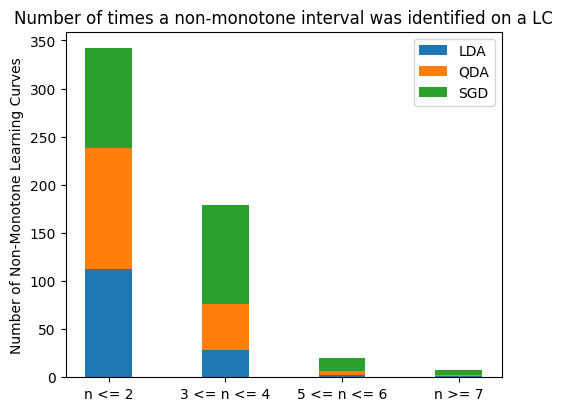

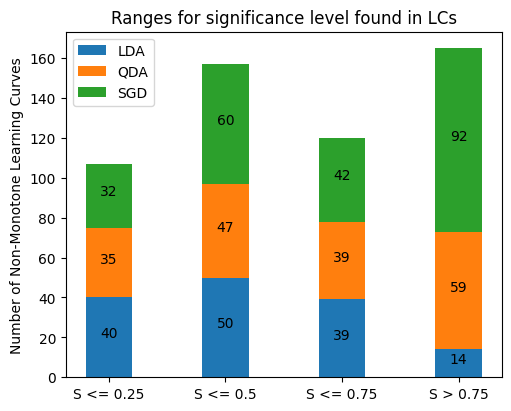

In [9]:
occurances_LDA = [occLDA1, occLDA2, occLDA3, occLDA4]
significances_LDA = [signLDA1, signLDA2, signLDA3, signLDA4]
occurances_QDA = [occQDA1, occQDA2, occQDA3, occQDA4]
significances_QDA = [signQDA1, signQDA2, signQDA3, signQDA4]
occurances_SGD = [occSGD1, occSGD2, occSGD3, occSGD4]
significances_SGD = [signSGD1, signSGD2, signSGD3, signSGD4]

plot_histogram_occurrences(occurances_LDA,occurances_QDA, occurances_SGD)
plot_histogram_significances(significances_LDA, significances_QDA, significances_SGD)

In [10]:
print(np.corrcoef(occurancesLDA, significancesLDA))
print(np.corrcoef(occurancesQDA, significancesQDA))
print(np.corrcoef(occurancesSGD, significancesSGD))

[[1.         0.21167576]
 [0.21167576 1.        ]]
[[1.         0.07559451]
 [0.07559451 1.        ]]
[[1.         0.20767266]
 [0.20767266 1.        ]]


In [11]:
experiment2_results = pd.DataFrame(rows, columns=['learner', 'dataset_id', 'non-monotone', 'occurrences', 'significance'])
experiment2_results

,learner,dataset_id,non-monotone,occurrences,significance
0,sklearn.discriminant_analysis.LinearDiscrimina...,6,False,0,0.000000
1,sklearn.discriminant_analysis.LinearDiscrimina...,11,False,0,0.000000
2,sklearn.discriminant_analysis.LinearDiscrimina...,12,True,1,0.079914
3,sklearn.discriminant_analysis.LinearDiscrimina...,14,True,1,0.142910
4,sklearn.discriminant_analysis.LinearDiscrimina...,16,False,0,0.000000
...,...,...,...,...,...
621,sklearn.linear_model.SGDClassifier,42734,True,3,0.547377
622,sklearn.linear_model.SGDClassifier,42742,True,4,1.000000
623,sklearn.linear_model.SGDClassifier,42769,True,4,0.301442
624,sklearn.linear_model.SGDClassifier,42809,True,3,0.364157


In [13]:
experiment2_results.to_csv('experiment2_results.csv')